# Coursera IBM Data Science Capstone Project
## _Overview of the Cafés map in Vienna, Austria_

_Author: Katerina Mincheva   
April, 2019_

__Contents:__
1. Introduction
2. Data
3. Methodology
4. Results and Conclusion

### 1. Introduction

Vienna is known for its strong coffee culture, which can be also recognized by the solid number of cafés and roasteries in the city, as well as the good quality of the coffee, that the Viennese highly value. It is a renowned cultural trait as well as a habit of the people to go out and enjoy fresh brewed coffee in local cafés. Furthermore, the vibrant city atmosphere, the big amount of students, as well as that of tourists that are looking to experience the coffee culture, secure the constant demand for such places. This is the reason why both established café owners seek to expand their businesses in new locations, as well as new entrants see the market as an attractive and never too saturated to enter. 

Thus, the aim of this report is to create an overview of the 'Café map' of Vienna that will have many uses. It will provide a cluster analysis and a valuable overview of the numbet of coffee places in each of Vienna's so-called districts. This could, on one hand, be used by entrepreneurs looking for opening a new café in the right location. However, it is also a tool that could help students or Vienna's visitors to choose, for example, an accommodation in an area with bigger saturation of renowned coffee places.

In a business perspective, we will look for an answer to the question: __Which districts of Vienna offer the most attractive location for opening a new café?__

### 2. Data

The data to be used in the scope of the project comes from few different sources:   
1. A Wikipedia article containing the needed information about the 23 different districts in Vienna, called 'Bezirke' (German): https://de.wikipedia.org/wiki/Wiener_Gemeindebezirke. In order to extract the required information - the number of the district and its name, that is contained in a table, web scrapping technique will be applied.
2. Location data - the coordinates of each district, will be then collected through the Python Geocoder. Having each district's coordinates will then be used in the next step.
3. Foursquare - after having each districts coordinates, analysis of all Café venues will be done by querying data and gathering all relevant information through the Foursquare API. Based on that, a clustering of the districts will be done.
4. In addition, from Statistics Austria we will extract info regarding the population of each district to later see if there are district with bigger population, but smaller amount of coffee places. http://statistik.at/web_en/statistics/index.html

### 3. Methodology


The first step is to gather the districts data and to create a dataframe with all the district names, their numbers, as well as their coordinates.

We will start by importing all required libraries and packages and then scrapping the Wikipedia page using the BeautifulSoup library.

In [1]:
from bs4 import BeautifulSoup
import lxml
import pandas as pd
import numpy as np
import requests
!pip install geocoder
import geocoder
import matplotlib.pyplot as plt #we also need libraries for visualization later
import seaborn as sns
%matplotlib inline 

from geopy.geocoders import Nominatim

!conda install -c conda-forge folium=0.5.0 --yes
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported')

    100% |████████████████████████████████| 102kB 8.2MB/s ta 0:00:01
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from geocoder)
Requirement not upgraded as not directly required: click in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from geocoder)
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from geocoder)
Requirement not upgraded as not directly required: future in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from geocoder)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->geocoder)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->geocoder)
Requirement not upgraded as not directly required: urllib3<1.23,>=1.21.1 in /opt/conda

#### 3.1 Data preprocessing
#### 3.1.1 District information

In [2]:
wiki_link = 'https://de.wikipedia.org/wiki/Wiener_Gemeindebezirke'

#let's get the source code of the website, that we need to extract the info from
source = requests.get(wiki_link).text

soup = BeautifulSoup(source, 'lxml') 
#print(soup.prettify())

In [3]:
#let's see if we got the right artice first
print(soup.title.text.split(' - ')[0])

Wiener Gemeindebezirke – Wikipedia


In [4]:
table = soup.find('table', class_='wikitable sortable zebra')
#print(table.prettify())

In [5]:
district_list = []
for row in table.find_all('tr'):
    data=row.find_all('th')
    district_list.append([i.text.strip() for i in data])
    
column_names = ['District_No', 'Name']
district_df = pd.DataFrame(columns= column_names,data=district_list[1:], index=None)

district_df = district_df[:23]
district_df.head()

,District_No,Name
0,01,Innere Stadt
1,02,Leopoldstadt
2,03,Landstraße
3,04,Wieden
4,05,Margareten


There are 23 districts in Vienna, let's check if our dataframe has them all:

In [6]:
print('The dataframe has {} districts.'.format(district_df.shape[0]))

The dataframe has 23 districts.


The postal code of each district is useful in determning it's coordinates later. This information can be again extracted from and online source, however, the postal codes in Vienna are easily formed by using the district number and adding a '1' in the beginning and '0' in the end. That's what we're doing in the next step, and simultaneously adding this to out dataframe. 

In [7]:
district_df['PostalCode'] = None
for i in range(0, district_df.shape[0]):
    pc=('1' + district_df['District_No'][i] + '0')
    district_df['PostalCode'][i] = pc

In [8]:
district_df

,District_No,Name,PostalCode
0,01,Innere Stadt,1010
1,02,Leopoldstadt,1020
2,03,Landstraße,1030
3,04,Wieden,1040
4,05,Margareten,1050
5,06,Mariahilf,1060
6,07,Neubau,1070
7,08,Josefstadt,1080
8,09,Alsergrund,1090
9,10,Favoriten,1100


#### 3.1.2 Districts' location data

Now, we need to add the location data to each district. For that we will use the GeoPy's Nominatum service.

In [9]:
#we will define a function for that
def get_latlng(postal_code):
    lat_lng_coord = None
    geolocator = Nominatim(user_agent="vn_explorer")
    
    while(lat_lng_coord is None):
        lat_lng_coord = geolocator.geocode('{}, Austria'.format(postal_code))
        latitude=lat_lng_coord.latitude
        longitude=lat_lng_coord.longitude
        return [latitude, longitude]

In [10]:
#let's call the function to get our coordinates and then add those to the dataframe
codes=[]
for i in range (0, district_df.shape[0]):
    codes.append(district_df['PostalCode'][i])
codes    
coordinates = [get_latlng(code) for code in codes]

district_df['Latitude'] = None
district_df['Longitude'] = None

for i in range(0, district_df.shape[0]):
    lat=coordinates[i][0]
    lon=coordinates[i][1]
    district_df['Latitude'][i] = lat
    district_df['Longitude'][i] = lon

In [11]:
district_df

,District_No,Name,PostalCode,Latitude,Longitude
0,01,Innere Stadt,1010,48.2061,16.3652
1,02,Leopoldstadt,1020,48.2064,16.4328
2,03,Landstraße,1030,48.1936,16.3963
3,04,Wieden,1040,48.1923,16.3714
4,05,Margareten,1050,48.1921,16.358
5,06,Mariahilf,1060,48.1955,16.347
6,07,Neubau,1070,48.2027,16.3471
7,08,Josefstadt,1080,48.2109,16.3474
8,09,Alsergrund,1090,48.2229,16.3564
9,10,Favoriten,1100,48.1804,16.3633


Now that we have all district information, we can go and visusualize this on a map using the Folium library.

In [12]:
address_vienna = 'Vienna, Austria'

geolocator = Nominatim(user_agent="vn_explorer")
location = geolocator.geocode(address_vienna)
lat_vienna = location.latitude
lon_vienna = location.longitude
print('The geograpical coordinates of Vienna are {}, {}.'.format(lat_vienna, lon_vienna))

map_vienna = folium.Map(location=[lat_vienna, lon_vienna], zoom_start=11)

# add markers to map
for lat, lng, no, district in zip(district_df['Latitude'], district_df['Longitude'], district_df['District_No'],district_df['Name']):
    label = '{}, {}'.format(no, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vienna)  
    
map_vienna

The geograpical coordinates of Vienna are 48.2083537, 16.3725042.


#### 3.1.3 Venues data

Next step will be to use the Foursquare API to find the relevant for us venues - the Cafés.

In [13]:
# @hidden_cell
CLIENT_ID = 'FE5Z4BE34BWUOWLLBGWVPOFGNN2SHHF13LNDJLKQT3AGKRMS'
CLIENT_SECRET ='KSSNOXFWS32B0A40M2O1J4N0TTDWAQXSVGZLHD43DZGOKQSG'
VERSION = '20190402'
LIMIT=100

Since we have our districts, we will now define a function that will locate all relevant for us venues in those:

In [14]:
search_query='Café' #since we're only looking for a specific type of venues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            search_query,
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
#let's use the function to get the information
vienna_cafes = getNearbyVenues(names=district_df['Name'],
                                   latitudes=district_df['Latitude'],
                                   longitudes=district_df['Longitude']
                                  )

Innere Stadt
Leopoldstadt
Landstraße
Wieden
Margareten
Mariahilf
Neubau
Josefstadt
Alsergrund
Favoriten
Simmering
Meidling
Hietzing
Penzing
Rudolfsheim-Fünfhaus
Ottakring
Hernals
Währing
Döbling
Brigittenau
Floridsdorf
Donaustadt
Liesing


In [16]:
print(vienna_cafes.shape)
vienna_cafes.head(15)

(190, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Innere Stadt,48.20608,16.365169,Café Mozart,48.204317,16.368987,Café
1,Innere Stadt,48.20608,16.365169,Demel – K.u.K. Hofzuckerbäcker,48.208545,16.367209,Café
2,Innere Stadt,48.20608,16.365169,Palmenhaus,48.204957,16.366855,Café
3,Innere Stadt,48.20608,16.365169,Café Central,48.210348,16.365391,Café
4,Innere Stadt,48.20608,16.365169,Café Sacher,48.203857,16.370144,Café
5,Innere Stadt,48.20608,16.365169,Le Bol,48.206469,16.370575,Café
6,Innere Stadt,48.20608,16.365169,Café Hawelka,48.207844,16.369849,Café
7,Innere Stadt,48.20608,16.365169,Gerstner K. u. K. Hofzuckerbäcker,48.203163,16.370269,Café
8,Innere Stadt,48.20608,16.365169,Filmmuseum Bar,48.204805,16.368793,Café
9,Innere Stadt,48.20608,16.365169,L. Heiner Hofzuckerbäcker,48.206205,16.371451,Café


In [17]:
cafes_map = folium.Map(location=[lat_vienna, lon_vienna], zoom_start=11)


for lat, lng, no, district in zip(district_df['Latitude'], district_df['Longitude'], district_df['District_No'],district_df['Name']):
    label = '{}, {}'.format(no, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(cafes_map)

# add popular spots to the map as blue circle markers
for lat, lng, label in zip(vienna_cafes['Venue Latitude'] , vienna_cafes['Venue Longitude'], vienna_cafes['Venue']):
    label = '{}'.format(label)
    label = folium.Popup(label, parse_html=True)
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6,
        parse_html=False
        ).add_to(cafes_map)

# display map
cafes_map

#### 3.1.4 Population data

Let's now upload the data for the population in each of Vienna's districts.

In [18]:
pop = pd.read_excel('http://www.statistik.at/wcm/idc/idcplg?IdcService=GET_NATIVE_FILE&RevisionSelectionMethod=LatestReleased&dDocName=080904',
                    skiprows=range(2187),
                    skip_footer=2,
                    usecols=("B,S"),
                    names=['District', 'Population_2018'])

In [19]:
pop

,District,Population_2018
0,"Wien 1., Innere Stadt",16450
1,"Wien 2., Leopoldstadt",105574
2,"Wien 3., Landstraße",90712
3,"Wien 4., Wieden",33319
4,"Wien 5., Margareten",55640
5,"Wien 6., Mariahilf",32069
6,"Wien 7., Neubau",32467
7,"Wien 8., Josefstadt",25662
8,"Wien 9., Alsergrund",42547
9,"Wien 10., Favoriten",201882


We can add this information to the dataframe we have with the rest of the information for each district.

In [20]:
district_df['Population_2018'] = pop['Population_2018'].astype(int)
district_df.head()

,District_No,Name,PostalCode,Latitude,Longitude,Population_2018
0,01,Innere Stadt,1010,48.2061,16.3652,16450
1,02,Leopoldstadt,1020,48.2064,16.4328,105574
2,03,Landstraße,1030,48.1936,16.3963,90712
3,04,Wieden,1040,48.1923,16.3714,33319
4,05,Margareten,1050,48.1921,16.358,55640


#### 3.2 Exploratory data analysis

Going back to the venue data that we gathered above: Let's see how many venues there are in each district that we got the data for. But first if we chech, we see that we don't even have venues of the type we look for in each district:

In [21]:
print('There are cafés in {} of the 23 districts in Vienna.'.format(len(vienna_cafes['District'].unique())))

There are cafés in 14 of the 23 districts in Vienna.


In [22]:
print('There are {} cafés in total in Vienna.'.format(vienna_cafes.shape[0]))

There are 190 cafés in total in Vienna.


Let's see where the cafés we have found are located:

In [23]:
cafes_by_district=vienna_cafes.groupby(['District']).count().reset_index()[['District', 'Venue']]
cafes_by_district.rename(columns={'Venue':"Cafe_Count", 'District':'Name'}, inplace=True)
cafes_by_district['Cafe_Count'].astype(int)
cafes_by_district.head()

,Name,Cafe_Count
0,Alsergrund,15
1,Döbling,2
2,Favoriten,2
3,Innere Stadt,50
4,Josefstadt,21


The amount of coffee places in each district is essential in our analysis. Therefore we add the cafés count to our dataframe. However, we saw that there is information about cafés on Foursquare in only 15 of our 23 districts. Therefore, when we merge the two dataframes we have, we use the 'left' merge option to still have all of our districts in the dataframe, and we fill out the blanks with '0's.

In [24]:
district_df=district_df.merge(cafes_by_district, on='Name', how='left').fillna(0)
district_df['Cafe_Count'].astype(int)
district_df

,District_No,Name,PostalCode,Latitude,Longitude,Population_2018,Cafe_Count
0,01,Innere Stadt,1010,48.206080,16.365169,16450,50.0
1,02,Leopoldstadt,1020,48.206421,16.432779,105574,0.0
2,03,Landstraße,1030,48.193644,16.396286,90712,3.0
3,04,Wieden,1040,48.192314,16.371367,33319,11.0
4,05,Margareten,1050,48.192125,16.357979,55640,17.0
5,06,Mariahilf,1060,48.195475,16.347023,32069,22.0
6,07,Neubau,1070,48.202668,16.347146,32467,36.0
7,08,Josefstadt,1080,48.210852,16.347360,25662,21.0
8,09,Alsergrund,1090,48.222930,16.356410,42547,15.0
9,10,Favoriten,1100,48.180410,16.363333,201882,2.0


In [25]:
chart_df = district_df[['Name', 'Cafe_Count']].set_index('Name')
chart_df

,Cafe_Count
Name,
Innere Stadt,50.0
Leopoldstadt,0.0
Landstraße,3.0
Wieden,11.0
Margareten,17.0
Mariahilf,22.0
Neubau,36.0
Josefstadt,21.0
Alsergrund,15.0


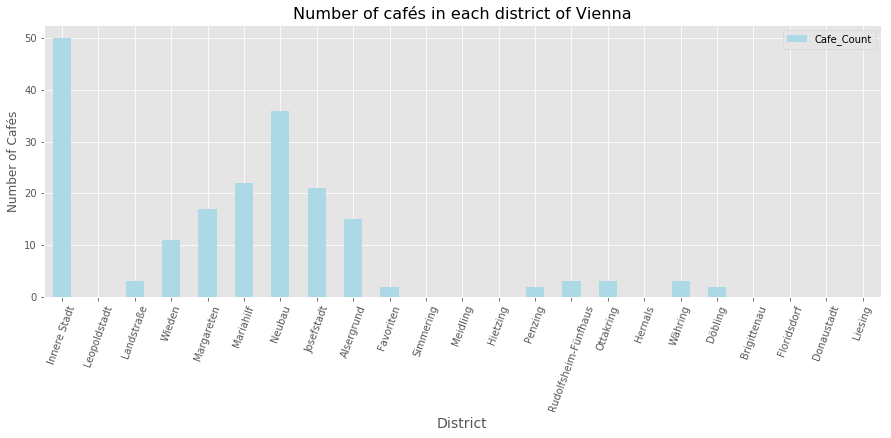

In [26]:
import matplotlib as mpl
mpl.style.use("ggplot")

chart_df.plot(kind='bar', figsize=(15,5), color='lightblue', rot=70)

plt.xlabel('District', size=14)
plt.ylabel('Number of Cafés')
plt.title('Number of cafés in each district of Vienna', size=16)
plt.show()

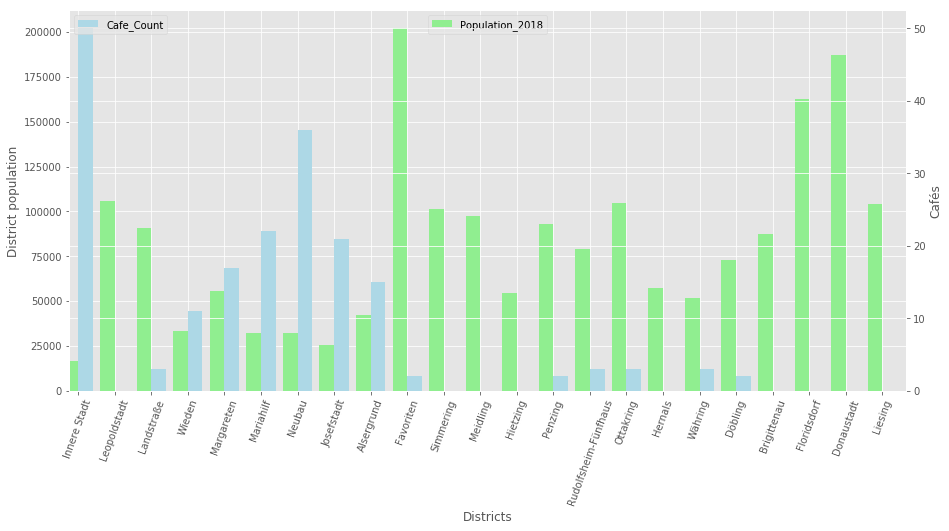

In [27]:
#test=district_df[['Name','Population_2018', 'Cafe_Count']].set_index('Name')
#test.plot(kind='bar', stacked=True, figsize=(12,5))
#plt.show()
fig=plt.figure(figsize=(15,7))
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

district_df.Population_2018.plot(kind='bar', color='lightgreen', ax=ax, width=width, position=1, rot=70)
chart_df.Cafe_Count.plot(kind='bar', color='lightblue', ax=ax2, width=width, position=0, rot=70)

ax.set_xlabel('Districts')
ax.set_ylabel('District population')
ax2.set_ylabel('Cafés')

ax.legend(loc=9)
ax2.legend(loc=2)

plt.show()


#### 3.3 Clustering

Now that we also have the café count, we can cluster the districts according to that. This will then give us important implications regarding the density of venues and the lack of such, respectively. By using the KMeans clustering, we will group the districts in 3 groups in total and then compare those to draw conclusions.

In [28]:
#we're gonna cluster the districts based on the amount of coffee places that exist there and then add the label to the df
k_clusters=3
cafes_clustering = district_df[['Cafe_Count']]

kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(cafes_clustering)

district_df.insert(7, 'Cluster_Label', kmeans.labels_)

In [29]:
district_df

,District_No,Name,PostalCode,Latitude,Longitude,Population_2018,Cafe_Count,Cluster_Label
0,01,Innere Stadt,1010,48.206080,16.365169,16450,50.0,2
1,02,Leopoldstadt,1020,48.206421,16.432779,105574,0.0,0
2,03,Landstraße,1030,48.193644,16.396286,90712,3.0,0
3,04,Wieden,1040,48.192314,16.371367,33319,11.0,1
4,05,Margareten,1050,48.192125,16.357979,55640,17.0,1
5,06,Mariahilf,1060,48.195475,16.347023,32069,22.0,1
6,07,Neubau,1070,48.202668,16.347146,32467,36.0,2
7,08,Josefstadt,1080,48.210852,16.347360,25662,21.0,1
8,09,Alsergrund,1090,48.222930,16.356410,42547,15.0,1
9,10,Favoriten,1100,48.180410,16.363333,201882,2.0,0


We have just clustered the districts in 3 groups and will now visualize those on the map to get a better overview. For that we will use different colors for the markers to indicate the group the districts are in.

In [30]:
# create map
map_clusters = folium.Map(location=[lat_vienna, lon_vienna], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k_clusters)
ys = [i + x + (i*x)**2 for i in range(k_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(district_df['Latitude'], district_df['Longitude'], district_df['Name'], district_df['Cluster_Label']):
    label = folium.Popup(str(poi) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

We can see which districts are in the different clusters, but let's explore those closer to see what their characteristics are.

### Cluster 1:

In [31]:
district_df.loc[district_df['Cluster_Label'] == 0, district_df.columns]

,District_No,Name,PostalCode,Latitude,Longitude,Population_2018,Cafe_Count,Cluster_Label
1,02,Leopoldstadt,1020,48.206421,16.432779,105574,0.0,0
2,03,Landstraße,1030,48.193644,16.396286,90712,3.0,0
9,10,Favoriten,1100,48.180410,16.363333,201882,2.0,0
10,11,Simmering,1110,48.163109,16.458009,101420,0.0,0
11,12,Meidling,1120,48.166045,16.324810,97624,0.0,0
12,13,Hietzing,1130,48.178541,16.252986,54265,0.0,0
13,14,Penzing,1140,48.200573,16.262219,92752,2.0,0
14,15,Rudolfsheim-Fünfhaus,1150,48.195475,16.326301,79029,3.0,0
15,16,Ottakring,1160,48.212704,16.313595,104627,3.0,0
16,17,Hernals,1170,48.235403,16.284214,57546,0.0,0


### Cluster 2:

In [32]:
district_df.loc[district_df['Cluster_Label'] == 1, district_df.columns]

,District_No,Name,PostalCode,Latitude,Longitude,Population_2018,Cafe_Count,Cluster_Label
3,04,Wieden,1040,48.192314,16.371367,33319,11.0,1
4,05,Margareten,1050,48.192125,16.357979,55640,17.0,1
5,06,Mariahilf,1060,48.195475,16.347023,32069,22.0,1
7,08,Josefstadt,1080,48.210852,16.347360,25662,21.0,1
8,09,Alsergrund,1090,48.222930,16.356410,42547,15.0,1


### Cluster 3:

In [33]:
district_df.loc[district_df['Cluster_Label'] == 2, district_df.columns]

,District_No,Name,PostalCode,Latitude,Longitude,Population_2018,Cafe_Count,Cluster_Label
0,01,Innere Stadt,1010,48.206080,16.365169,16450,50.0,2
6,07,Neubau,1070,48.202668,16.347146,32467,36.0,2


### 4. Results and conclusion

We can see that the model has segmented the districts and by looking at the density of coffee places in each, we observe that the districts in the Cluster 3 have the biggest count on cafés, the ones in Cluster 2 have between 11 and 21 location, while the districts in Cluster 1 have a maximum of 3 cafés.

In addition, we have before observed the distribution of population among all districts and the results indicate that the 5 districts with the most population have either no, or a maximum of two coffee places. This speaks for a certain disproportionality between people and café locations. All of them were place by the model in Cluster 1.

This allows for the conclusion, that namely the districts in Cluster 1 offer the most attractive location for opening a new café. Although, by looking at the map, one notices that they are further away from the city center, the lack of cafés and the big amount of inhabitants speaks for the potentially unmet demand, that early entrants can make a big use of. 
